# (Appendix) Capstone Project Part 2: Feature Engineering and Modeling

**Author:** Soohyun Ahn <br>
    
**Date:** April 2023<br>

**Notebook Number:** 2/ 4 (in the **Appendix** folder)

**IMPORTANT REMINDER**: 
This notebook is supplementary to the main notebook, [Part_2_Feature_Engineering_Modeling](https://github.com/treelunar/2023_Capstone/blob/main/Part_2_Feature_Engineering_Modeling.ipynb).<br>Readers interested in the capstone project should primarily follow the main notebooks and refer to the supplementary notebooks if they wish to explore further.

In Part 1, we performed data cleaning and preprocessing on our dataset.<Br>Now we can move on to feature engineering, which involves text vectorization and creating word embeddings.

In this notebook, we will cover feature engineering, which involves transforming raw text data into a set of meaningful features that machine learning algorithms can use. Text vectorization and creating word embeddings are the key steps involved in feature engineering.

**Text vectorization** involves using techniques like Bag of Words (BoW), TF-IDF, and Word2Vec to convert text data into numerical vectors. We will be using CountVectorizer to create vector representations, followed by `k-Means` clustering and `silhouette analysis` to evaluate the quality of the clusters.
    
**Word embeddings**, on the other hand, are a type of vector representation that maps each word to a high-dimensional vector in a continuous vector space. This allows machine learning algorithms to learn the semantic relationships between words and make predictions accordingly. We will compare two word embedding models - LexVec and OpenAI's ada language model.

`LexVec` is an embedding technique that captures complex semantic relationships between words, such as analogies. It is trained on a large corpus of text, such as Wikipedia articles.

`OpenAI's ada` language model, on the other hand, is a state-of-the-art technology for natural language processing that can capture synonyms, antonyms, and other nuanced relationships between words.

Overall, through feature engineering, we will create vector representations and embeddings that will help us to better understand and analyze our text data.

In [125]:
import pandas as pd
import numpy as np
import tiktoken # need to pip install  
import openai # need to pip install
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set the random seed

random.seed(42)
np.random.seed(42)

# hide warnings

import warnings
warnings.filterwarnings('ignore')

In [126]:
# Read in dataset, which is already cleaned and preprocessed from the earlier notebook

df = pd.read_csv('mpst_cleaned.csv', sep=',')
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...


Check the dataframe to see any missing values before creating embeddings.

In [127]:
# Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14828 non-null  object
 1   title            14828 non-null  object
 2   plot_synopsis    14828 non-null  object
 3   tags             14828 non-null  object
 4   split            14828 non-null  object
 5   synopsis_source  14828 non-null  object
 6   en_title         439 non-null    object
 7   overview         14828 non-null  object
dtypes: object(8)
memory usage: 926.9+ KB


In [57]:
# Check the number of rows with missing values

num_missing = df['overview'].isna().sum()
print(f"Number of rows with missing values: {num_missing}")

Number of rows with missing values: 0


According to [OpenAI](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings) documentation for word embeddings, the ada v2 embedding model can take up to 8,191 tokens. as maximum input token. So, we need to check whether the tokens from any of the plot exceeds the maximum number.

In [128]:
# Create a new column that contains the number of tokens in the `clean_plot`
df['num_tokens'] = df['overview'].apply(lambda x: len(x.split()))

# Find out the maximum and minimum number of tokensb
max_tokens = df['num_tokens'].max()
min_tokens = df['num_tokens'].min()
print(f"Maximum number of tokens: {max_tokens}")
print(f"Minimum number of tokens: {min_tokens}")

Maximum number of tokens: 5522
Minimum number of tokens: 42


The `clean_plot` column does not have plots that exceed the maximum number.

In [129]:
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...,619
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...,189
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...,335
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...,1074
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...,1366


The `get_embedding()` function expects a string as input. Thus, we need to check the data type of the `clean_plot` column before getting the embeddings.

In [130]:
# Check the data type of the `overview` column

is_string = df['overview'].apply(lambda x: type(x) == str).all()
if is_string:
    print("All elements in the column are strings")
else:
    print("The column contains non-string values")

All elements in the column are strings


We have confirmed that the column contains strings.

## Creating Text Vectors - `CountVectorizer`
By using `CountVectorizer`, we can create a bag of words representation of the synopses, compare different movies based on their similarity in terms of the frequency of certain words in their synopses. Later, we can apply `K-Means` clustering to the text vectors.

In [131]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate 
bagofwords = CountVectorizer()

# Fit 
bagofwords.fit(df['overview'])

# Transform
transformed = bagofwords.transform(df['overview'])
transformed

<14828x88744 sparse matrix of type '<class 'numpy.int64'>'
	with 4007156 stored elements in Compressed Sparse Row format>

In [9]:
bagofwords.get_feature_names()

['aa',
 'aaa',
 'aaaaarrrrrrggghhh',
 'aaaahhh',
 'aaaiiigh',
 'aaarrghh',
 'aaay',
 'aadhi',
 'aadi',
 'aadil',
 'aagh',
 'aah',
 'aahil',
 'aai',
 'aaina',
 'aakash',
 'aakrosh',
 'aalavandhan',
 'aaliyah',
 'aamir',
 'aan',
 'aana',
 'aang',
 'aangre',
 'aannd',
 'aap',
 'aapke',
 'aar',
 'aardvark',
 'aargh',
 'aarmco',
 'aarmcos',
 'aarna',
 'aarne',
 'aaron',
 'aaronow',
 'aarthi',
 'aarthy',
 'aarti',
 'aashirvaad',
 'aashish',
 'aasif',
 'aasiya',
 'aata',
 'aati',
 'aatmalingam',
 'aatta',
 'aaya',
 'aayan',
 'ab',
 'aba',
 'ababa',
 'aback',
 'abaddon',
 'abajo',
 'abalone',
 'aban',
 'abandon',
 'abandonada',
 'abandonado',
 'abandonados',
 'abandonaron',
 'abandonded',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandonned',
 'abani',
 'abarrotada',
 'abarrotado',
 'abashed',
 'abashedly',
 'abasi',
 'abatantuono',
 'abate',
 'abated',
 'abates',
 'abating',
 'abattoir',
 'abazai',
 'abb',
 'abba',
 'abbadon',
 'abbasi',
 'abbatoir',
 'abberline',
 'abberton',
 'abberton

In [132]:
from scipy.sparse import save_npz, load_npz
#save_npz('text_vectors_mpst.npz', transformed)

## Modeling: Silhouette Analysis and Clustering with `K-means` 

`K-means` clustering is an unsupervised machine learning algorithm used to partition a given dataset into $K$ number of clusters, where $K$ is a user-defined parameter. Although text vectors created using `CountVectorizer` are not document embeddings, they can still be used as a representation of the characteristics of each document. `K-means` clustering can identify groups of documents with similar characteristics based on the similarity of their text vectors. This can help to identify patterns and similarities between them, which is useful for tasks like recommendation systems. Determining the optimal value for `n_clusters` can be challenging, but starting with 5 or the number of existing movie genres, such as 13, which corresponds roughly to common movie genres, can be a good starting point. 

`t-SNE` is a powerful nonlinear dimensionality reduction technique that can convert high-dimensional data into lower-dimensional representations for effective data visualization. Using the TSNE `n_components=2` function, we can convert text vectors into a 2D space that can be easily plotted and analyzed. To determine the ideal $K$ number in `K-means`, the `silhouette_score` metric is commonly used. It measures the similarity of the points to their assigned clusters relative to the other clusters they are not assigned to. High Silhouette Scores and clear separation between clusters indicate the best clustering. 

To visualize the clustering results, we will display the silhouette plot and the scatter plot side by side for each number of clusters, making it easier to compare visually.

In [ ]:
#pip install --upgrade threadpoolctl

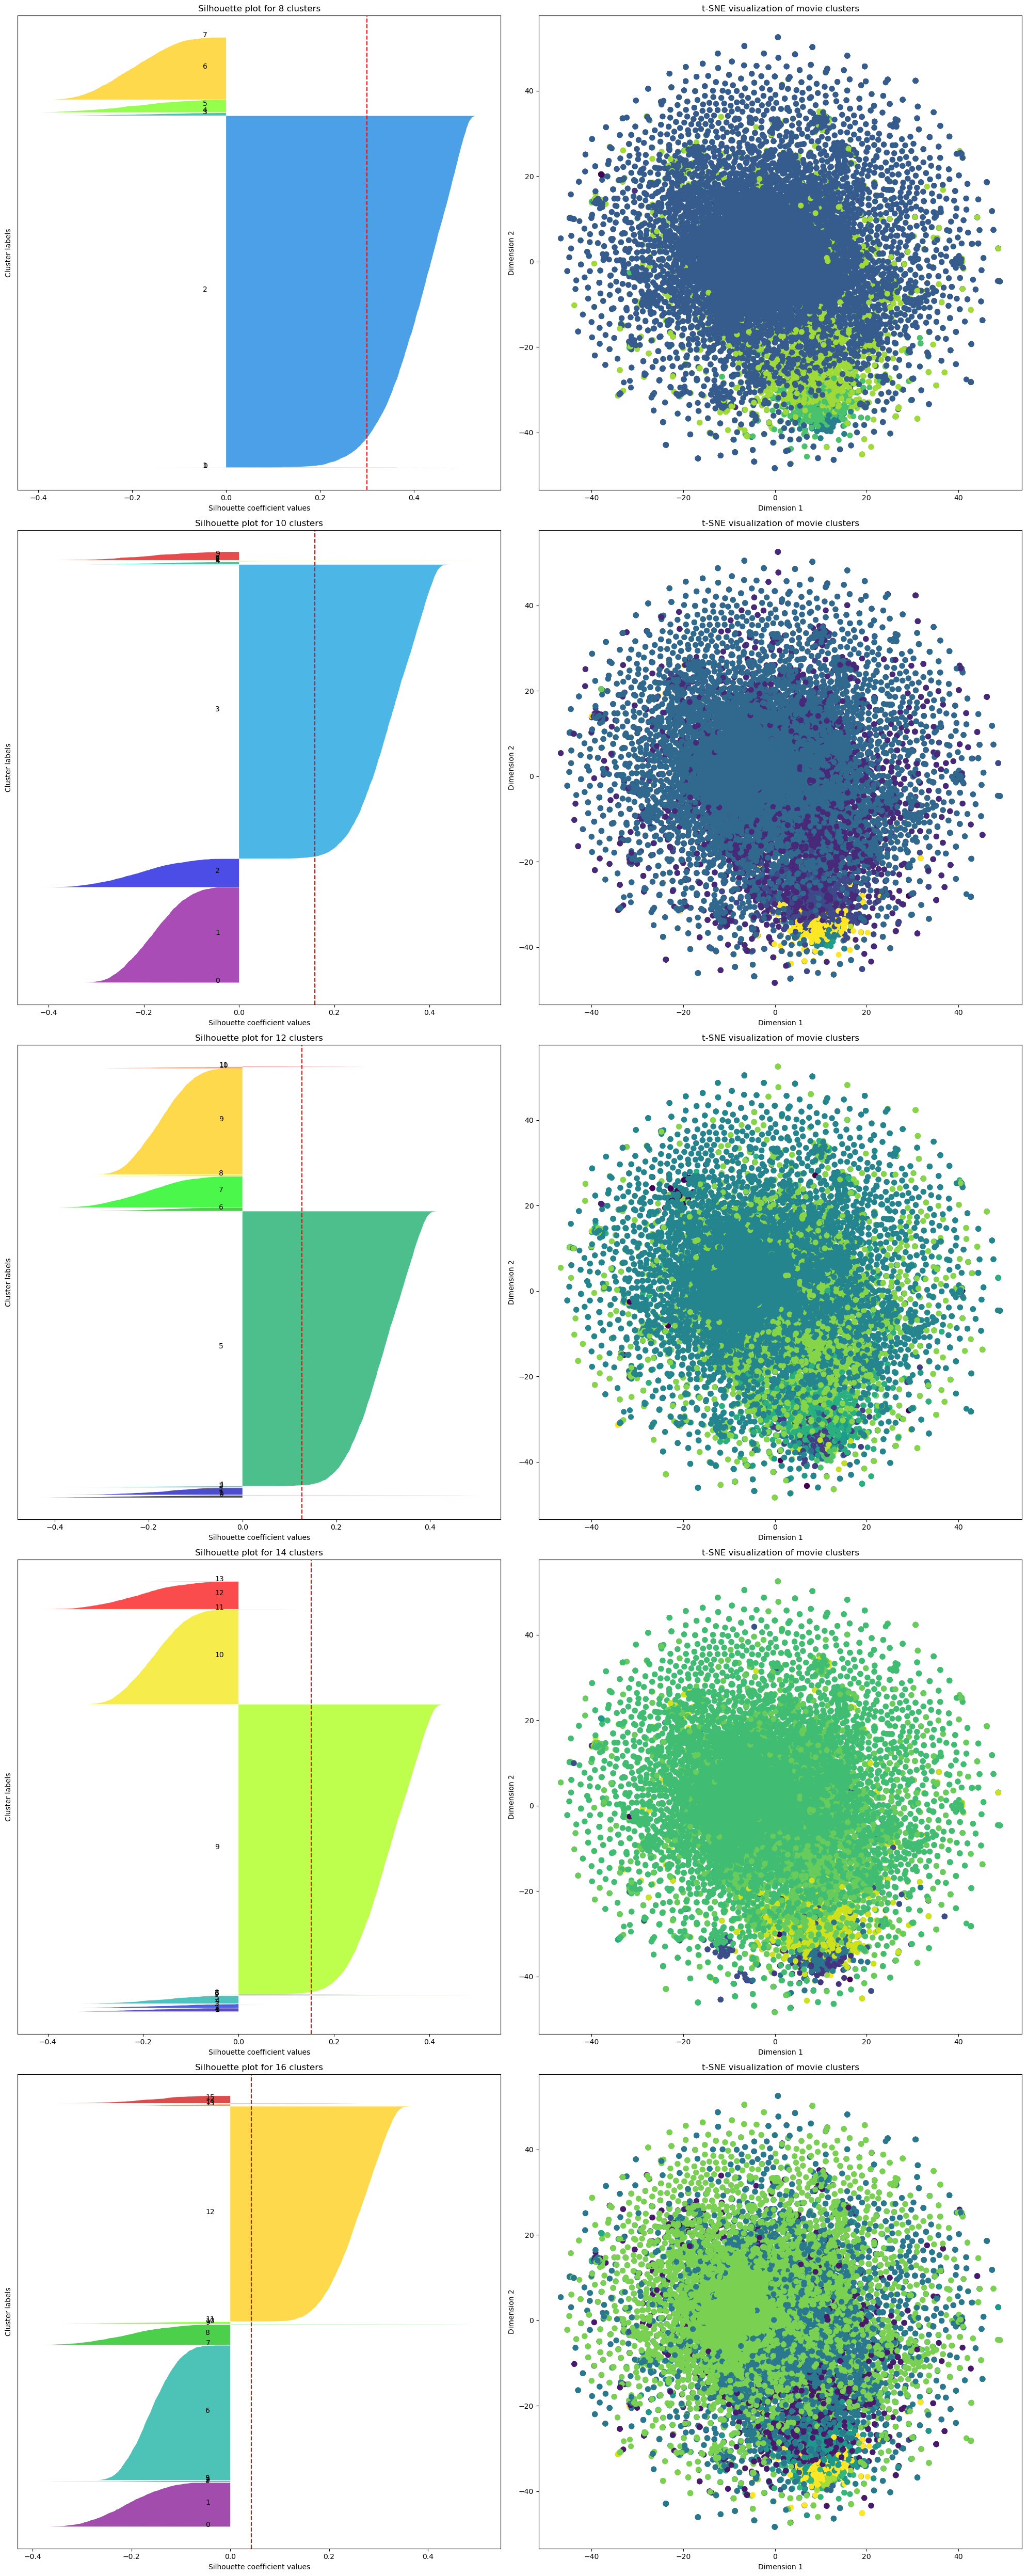

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.manifold import TSNE

range_n_clusters = [8, 10, 12, 14, 16]
fig, axs = plt.subplots(len(range_n_clusters), 2, figsize=(20, 10*len(range_n_clusters)))

for i, n_clusters in enumerate(range_n_clusters):
    
    # Initialize the KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(transformed)

    # Calculate the silhouette score for the clustering
    silhouette_avg = silhouette_score(transformed, cluster_labels)

    # Calculate the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(transformed, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / n_clusters)
        axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[i, 0].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    axs[i, 0].set_title("Silhouette plot for {} clusters".format(n_clusters))
    axs[i, 0].set_xlabel("Silhouette coefficient values")
    axs[i, 0].set_ylabel("Cluster labels")
    axs[i, 0].axvline(x=silhouette_avg, color="red", linestyle="--")
    axs[i, 0].set_yticks([])

    # Visualize the clusters with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(transformed)
    cmap = plt.cm.get_cmap('viridis', n_clusters)
    axs[i, 1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap=cmap, s=50)
    axs[i, 1].set_title('t-SNE visualization of movie clusters')
    axs[i, 1].set_xlabel('Dimension 1')
    axs[i, 1].set_ylabel('Dimension 2')
    
plt.tight_layout()
plt.show()

Unfortunately, both silhouette plots and scatter plots are not helpful for us to determine the optimal value of $K$.

Let's draw scree plots for both `K-means` and `silhouette_score`. The number of clusters that should be chosen is the "elbow" point in the scree plot, where adding another cluster does not result in a significant reduction in the the total within-cluster sum of squares (WCSS).

The inertia is a measure of how far the points within a cluster are from the centroid of that cluster.

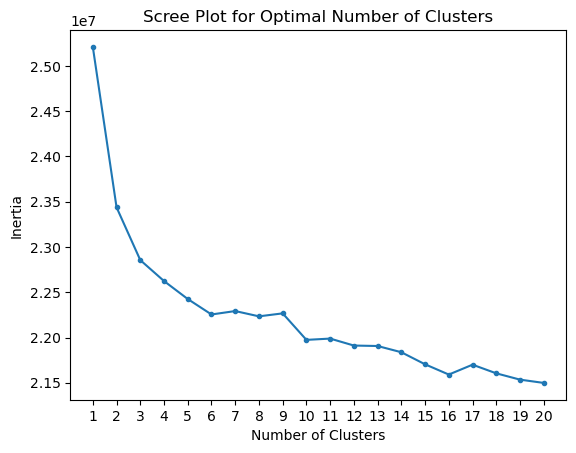

In [15]:
# Calculate the sum of squared distances (inertia) for different numbers of clusters

inertia_list = []
num_clusters = range(1, 21)

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(transformed)
    inertia_list.append(kmeans.inertia_)

# Draw the elbow plot (sum of squared distances vs. number of clusters)

plt.figure()
plt.plot(num_clusters, inertia_list, marker=".")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for Optimal Number of Clusters')
plt.xticks(num_clusters)
plt.show()

In general, the elbow of the plot (where the rate of decrease in inertia starts to level off) indicates a good number of clusters to use for the data. Certainly, it can be debatable about which point should be considered as an elbow point.

We can move on to silhouette analysis using a scree plot. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The higher the silhouette score, the better the clustering. The list of silhouette scores for each value of $K$ can be plotted to visualize the optimal value of $K$ that maximizes the silhouette score.

In [16]:
# A range of K values
k_range = np.arange(2, 20)

# Instantiate an empty list of silhouette scores
silhouette_scores = []

# Iterate over ks
for k in k_range:
    
    # Instantiate
    k_means_model = KMeans(n_clusters=k)

    # Fit
    k_means_model.fit(transformed)
    
    # Get cluster labels and calculate silhouette score
    cluster_labels = k_means_model.predict(transformed)
    silhouette = silhouette_score(transformed, cluster_labels)
    
    # Append to list
    silhouette_scores.append(silhouette)

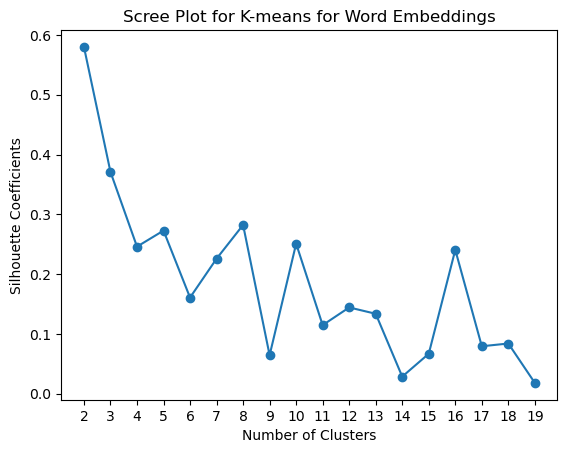

In [17]:
# Plot the silhouette 

plt.figure()
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')
plt.title('Scree Plot for K-means for Word Embeddings')
plt.xticks(k_range)
plt.show()

The above plot shows the silhouette coefficients for a range of $K$ values in `K-means` clustering for word embeddings.<br>It is very difficult to identify the optimal value of $K$ that maximizes the silhouette score.

Since both silhouette analysis and Kmeans clustering show that the quality of clustering is very low, then we can tentatively conclude that the dataset does not have clear clusters based on the features used in the analysis. We can explore other options, such as creating document embeddings.

## Document Embeddings 

Document embeddings provide a powerful way of representing the meaning of an entire document as a single vector, by combining the individual word embeddings. Typically, the word embeddings are averaged, or weighted by their importance, to obtain the document embedding. In our case, we will use two models, `LexVec` and `OpenAI`, to create two different document embeddings.

The use of document embeddings has several advantages over the traditional bag-of-words representation, as it can capture more semantic information about the documents, leading to better clustering results. Both `LexVec` and `OpenAI` are state-of-the-art techniques for creating document embeddings, and have demonstrated their efficacy in various natural language processing tasks. By utilizing these techniques to create document embeddings, we can potentially capture more meaningful and relevant information about the movie synopses, which can provide deeper insights into the similarities and differences between the movies.

## `LexVec`

The `LexVec` is a modification of the `word2vec` model and was designed to capture semantic relationships between words. We will use the 300-dimensional version, which was trained on the entire English Wikipedia.

In [133]:
#nltk.download('punkt')
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import cosine as cosine_distance

In [134]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec-wikipedia-word-vectors', binary=False
)

In [135]:
def document2vec(text):
    """
    Embed a document by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    # Preprocess text
    cleaned_text = simple_preprocess(text, deacc=True) # Removes accents (e.g. converting "é" to "e")
    
    # Filter tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokenized = [word for word in cleaned_text if word not in stop_words and word.isalpha()]

    # Embed words
    word_embeddings = []
    for word in filtered_tokenized:
        
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # Average word vectors
    if word_embeddings:
        sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    else:
        sentence_embedding = np.zeros(300)
    
    return sentence_embedding

To compare `cosine_distance` and `euclidean_distance`, we need to define `euclidean_distance`.

In [136]:
from numpy.linalg import norm

def euclidean_distance(u, v):
    """
    Calculate the Euclidean distance between two vectors.
    -----
    
    Input: u, v (np.array)
    Output: distance (float)
    """
    return np.linalg.norm(u - v)

Let's compare the first three movies we see in our dataset: `The Shop Around the Corner`, `Mr. Holland's Opus`, and `Scarface`.

In [60]:
emb2 = document2vec(df['overview'][2]) # The Shop Around the Corner
emb3 = document2vec(df['overview'][3]) # Mr. Holland's Opus
emb4 = document2vec(df['overview'][4]) # Scarface

In [61]:
# Compute both distances together

cosine_dist = cosine_distance(emb2, emb3) # The Shop Around the Corner vs Mr. Holland's Opus
euclidean_dist = euclidean_distance(emb2, emb3) # The Shop Around the Corner vs Mr. Holland's Opus

print(f"Cosine distance between {df['title'][2]} and {df['title'][3]} is {cosine_dist:.3f}")
print(f"Euclidean distance between {df['title'][2]} and {df['title'][3]} is {euclidean_dist:.3f}")

Cosine distance between The Shop Around the Corner and Mr. Holland's Opus is 0.108
Euclidean distance between The Shop Around the Corner and Mr. Holland's Opus is 0.334


In [62]:
# Compute both distances together

cosine_dist = cosine_distance(emb2, emb4) # The Shop Around the Corner vs Scarface
euclidean_dist = euclidean_distance(emb2, emb4) # The Shop Around the Corner vs Scarface

print(f"Cosine distance between {df['title'][2]} and {df['title'][4]} is {cosine_dist:.3f}")
print(f"Euclidean distance between {df['title'][2]} and {df['title'][4]} is {euclidean_dist:.3f}")

Cosine distance between The Shop Around the Corner and Scarface is 0.093
Euclidean distance between The Shop Around the Corner and Scarface is 0.309


In [63]:
# Compute both distances together

cosine_dist = cosine_distance(emb3, emb4) # Mr. Holland's Opus vs Scarface
euclidean_dist = euclidean_distance(emb3, emb4) # Mr. Holland's Opus vs Scarface

print(f"Cosine distance between {df['title'][3]} and {df['title'][4]} is {cosine_dist:.3f}")
print(f"Euclidean distance between {df['title'][3]} and {df['title'][4]} is {euclidean_dist:.3f}")

Cosine distance between Mr. Holland's Opus and Scarface is 0.119
Euclidean distance between Mr. Holland's Opus and Scarface is 0.339


We utilized `LexVec` to generate document embeddings for three movies: **The Shop Around the Corner**, **Mr. Holland's Opus**, and **Scarface**.<br>We then computed the cosine distance and Euclidean distance between each pair of movies. While these results are limited in scope, we can visualize them by drawing a triangle for each distance metric, with each point representing a movie and the length of each side reflecting the distance between the corresponding movies.

- cosine distance suggests that **The Shop Around the Corner** and **Mr. Holland's Opus** are closest to one another than the other movies.
- Euclidean distance suggests that **The Shop Around the Corner** and **Scarface** are closest to one another than the other movies.

- cosine distance suggests that **Mr. Holland's Opus** and **Scarface** are the least similar to one another than the other movies.
- Euclidean distance suggests that **Mr. Holland's Opus** and **Scarface** are the least similar to one another than the other movies.

The distance calculation seems reasonable.

Let's create three additional document embeddings using `LexVec` and compare the cosine distance and euclidean distance between them. This time, we will intentionally choose two movies that are more similar to each other than the remaining one.

Our selection includes **Mortal Kombat** and **Scarface**, which are quite dissimilar since one is a fantasy and adventure movie while the other is more crime-oriented. However, they share similarities such as having lots of action scenes and being quite violent. The third movie, **Up**, is entirely different from the other two. **Up** is an animated, family-oriented adventure that can be enjoyed by all ages. It tells a beautiful story that is heartwarming to watch.

By comparing these three movies using the two types of distances, we can gain insights into their similarities and differences.

In [137]:
# Find out the index number of `Mortal Kombat` 
df[df['title'] == "Mortal Kombat"]

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens
4527,tt0113855,Mortal Kombat,The series takes place in a fictional universe...,"['murder', ' cult', ' alternate reality', ' vi...",train,wikipedia,NaN,series take place fictional universe consistin...,469
13149,tt0203701,Mortal Kombat,The series takes place in a fictional universe...,"['violence', ' murder']",val,wikipedia,NaN,series take place fictional universe consistin...,469
14767,tt1842127,Mortal Kombat,The series takes place in a fictional universe...,"['good versus evil', ' paranormal', ' violence']",val,wikipedia,NaN,series take place fictional universe consistin...,469
14769,tt1386939,Mortal Kombat,The series takes place in a fictional universe...,"['revenge', ' violence']",val,wikipedia,NaN,series take place fictional universe consistin...,469


Okay. So, there are 4 [**Mortal Kombat**](https://www.imdb.com/title/tt0113855/?ref_=kw_li_tt) and the first one with `imdb_id` tt0113855 seems to be the first among the seires. Let's choose it.

In [138]:
# Find out the index number of `Up`
df[df['title'] == "Up"]

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens
2960,tt1049413,Up,"Young Carl Fredricksen (Jeremy Leary), a quiet...","['comedy', ' boring', ' depressing', ' dramati...",val,imdb,NaN,young quiet bespectacled boy wearing old pilot...,884


In [34]:
# Generate embeddings for each movie

emb4 = document2vec(df['overview'][4]) # Scarface
emb2960 = document2vec(df['overview'][2960]) # Up
emb4527 = document2vec(df['overview'][4527]) # Mortal Kombat

This time, instead of showing calculated numbers, we will create a scatter plot to compare two distance metrics.

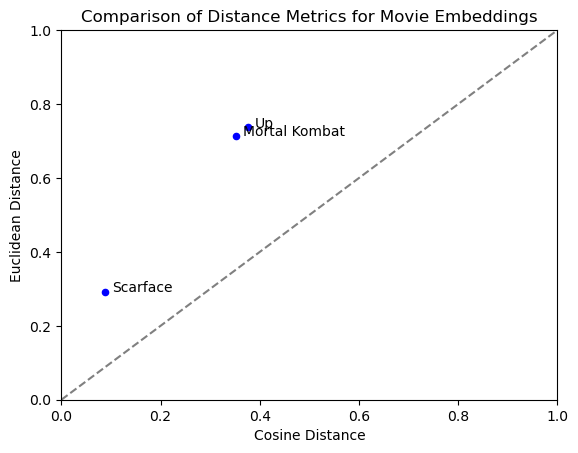

In [66]:
# Calculate cosine distance
cosine_dist_scarface_up = cosine_distance(emb4, emb2960)
cosine_dist_scarface_kombat = cosine_distance(emb4, emb4527)
cosine_dist_up_kombat = cosine_distance(emb2960, emb4527)

# Calculate Euclidean distance
euclidean_dist_scarface_up = euclidean_distance(emb4, emb2960)
euclidean_dist_scarface_kombat = euclidean_distance(emb4, emb4527)
euclidean_dist_up_kombat = euclidean_distance(emb2960, emb4527)

# Create a list of distances for both metrics
cosine_dists = [cosine_dist_scarface_up, cosine_dist_scarface_kombat, cosine_dist_up_kombat]
euclidean_dists = [euclidean_dist_scarface_up, euclidean_dist_scarface_kombat, euclidean_dist_up_kombat]

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Distance Metrics for Movie Embeddings')

# Plot the distances
ax.scatter(cosine_dists, euclidean_dists, s=20, c='blue')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal line for reference

# Add movie names as labels
movies = ['Scarface', 'Mortal Kombat', 'Up']
for i, movie in enumerate(movies):
    ax.annotate(movie, (cosine_dists[i], euclidean_dists[i]), xytext=(5, 0), textcoords='offset points')

plt.show()

It is known that when it comes to text embeddings, the cosine distance is generally preferred as it measures the semantic similarity between the texts, whereas the Euclidean distance measures the syntactic similarity.

The smaller the perpendicular distance, the closer the point is to the diagonal line, indicating a stronger agreement between the two distance metrics.

The points are tilted toward the left-bottom direction suggests that the cosine distance metric is a better indicator of similarity than the Euclidean distance metric. **Mortal Kombat** and **Up** are more similar to each other than **Scarface**, and that the cosine distance metric is a better measure of similarity for text embeddings than the Euclidean distance metric.

## Connecting to the API

In this section we will set our API key and send a request to verify that we can send a request.<br>To do so, you need to get yourself a private API key first by signing up to create your account. Check [here](https://beta.openai.com/signup).

In [139]:
# copy and paste your personal api key inbetween the quotation marks and then execute the below code
#openai.api_key = "..."

In [140]:
# list models as a quick test
models = openai.Model.list()

# print the first model's id
print(models.data[0].id)

babbage


In [141]:
# test if we can send a request

completion = openai.Completion.create(model="ada", prompt="Hello world")
print(completion['choices'][0].text)

.

Amortized time (.pmol): {your total number of


## Embedding Movie Synopses

Now we will use the `text-embedding-ada-002` to get word embeddings.

In [143]:
# Import `get_embedding`
from openai.embeddings_utils import get_embedding

# Embedding model parameters

embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # This is the encoding for text-embedding-ada-002
max_tokens = 8000

In [144]:
# Getting the embeddings took an hour (with a paid account)
# Do not run the below code unless you want to get the embeddings for yourself.

#df['ada_embeddings'] = df.overview.apply(lambda x: get_embedding(x, engine=embedding_model))
#df.to_csv('ada_embeddings_mpst_v3.csv', index=False)

## Inspect Embeddings

Now that we have word embeddings saved as a csv file, we will read in the file and use it from now on.

In [145]:
# Read in the csv file

ada_mpst_df = pd.read_csv('ada_embeddings_mpst_v3.csv', sep=',')
ada_mpst_df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"['cult', ' horror', ' gothic', ' murder', ' at...",train,imdb,NaN,note synopsis orginal italian release segment ...,619,"[0.0016248829197138548, -0.017225325107574463,..."
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",['violence'],train,imdb,NaN,two thousand year ago nhagruul foul sorcerer r...,189,"[-0.0006041820743121207, -0.005067169666290283..."
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",['romantic'],test,imdb,NaN,gift store budapest workplace newly hi work co...,335,"[-0.012049819342792034, -0.013357013463973999,..."
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","['inspiring', ' romantic', ' stupid', ' feel-g...",train,imdb,NaN,morning person anyone standard woken wife earl...,1074,"[-0.009851133450865746, 0.0006267587887123227,..."
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","['cruelty', ' murder', ' dramatic', ' cult', '...",val,imdb,NaN,may cuban man named claim asylum florida usa s...,1366,"[-0.023126397281885147, -0.010317284613847733,..."


In [146]:
ada_mpst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14828 non-null  object
 1   title            14828 non-null  object
 2   plot_synopsis    14828 non-null  object
 3   tags             14828 non-null  object
 4   split            14828 non-null  object
 5   synopsis_source  14828 non-null  object
 6   en_title         439 non-null    object
 7   overview         14828 non-null  object
 8   num_tokens       14828 non-null  int64 
 9   ada_embeddings   14828 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.1+ MB


## Experiment with the Embeddings

Let's expriment with the embeddings to see how our model functions well. Cosine distance is a measure of similarity between two vectors in a high-dimensional space. In this project, we use cosine distance to compare the embeddings of different movie plots. We can compute the cosine distance between any two plots using the `cosine()` function from `scipy.spatial.distance`. The cosine distance ranges from 0 (completely dissimilar) to 1 (identical). The cosine distance allows us to get the most similar moveies as well as the most dissimilar movies.

We choose the movie "Mr.Holland's Opus" as our sample (only because it's shown when we check the first few rows).

In [147]:
# sample plot ("Mr. Holland's Opus")

sample_plot = ada_mpst_df[['overview','ada_embeddings']].iloc[3,:] # Row with index=3
print(sample_plot['overview'])

morning person anyone standard woken wife early one bright september morning taken job music teacher newly renamed intends job sabbatical touring musician hope free time compose however soon find job teacher time consuming first thought arrives school first time meet vice comment corvair model car wrote book inside building meet got awkward start go music room meet student first time student dull apathetic mostly terrible musician lunchtime meet football coach strike friendship end stressful first day talk future everything go according plan paycheck made photography able quit four year go back music including composing notice one dedicated inept clarinet player start working individually continues attempting teach class music continues working music home time pass grading paper gradually replaces working music home time much chagrin several month exasperated seems none student learned anything class despite diligent practice improve clarinet playing exasperation compounded principal j

By using cosine distance to find the most dissimilar (i.e., least similar) movie plot to a given sample plot.

In [148]:
import ast

max_distance = 0
row_index = 0

# Convert the string representation of the sample_plot embeddings to an actual NumPy array and flatten it
sample_plot_embeddings = np.array(ast.literal_eval(sample_plot['ada_embeddings'])).flatten()

# Iterate through each row and compute the cosine distance between the sample_plot and all other plots
while row_index < ada_mpst_df.shape[0]:  
    
    # Convert the string representation of the array to an actual NumPy array and flatten it
    cur_embeddings = np.array(ast.literal_eval(ada_mpst_df['ada_embeddings'].iloc[row_index])).flatten()
    
    # Compute the cosine distance between the sample plot and the current plot
    cur_distance = cosine(sample_plot_embeddings, cur_embeddings)

    # Update max_distance and doc if cur_distance is greater than max_distance and is not 1
    if (cur_distance > max_distance) & (cur_distance != 1):  # The maximum possible cosine distance is 1 
        
        max_distance = cur_distance
        doc = ada_mpst_df['overview'].iloc[row_index]
    
    row_index += 1

In [149]:
# The movie plot which has the highest cosine distance from the sample plot (Mr.Holland's Opus)
doc

'final event mortal kombat deadly alliance raiden warrior meant protect six fictional universe named realm killed deadly alliance attempted conquer realm raiden defeated deadly alliance dissolve two sorcerer turn shinnok amulet win dragon king former emperor realm outworld appears regain power raiden awakes unleashes power colossal explosion apart destroying member deadly alliance surrounding palace little effect seek use six artifact called kamidogu literally tool god divine clay able destroy realm fighter survive battle deadly alliance stand supporter latter include force edenia led mileena titular theme deception masquerade sister princess enemy include former defender realm resurrected control story explored konquest mode young man named deceived spending life collecting kamidogu us guise emissary elder god being created realm named reveals identity intention gathered kamidogu shujinko led believe working greater good decides continue training defeat'

This is the plot of the movie, "Mortal Kombat"!

In [150]:
# Calculate distance between the two movies
max_distance

0.26883228762190825

Our model finds ["Mortal Kombat"](https://www.imdb.com/title/tt0293429/) as the least similar movie to the ["Mr.Holland's Opus"](https://www.imdb.com/title/tt0113862/?ref_=ttfc_fc_tt).<br>Even if you haven't watched any of the two movies, based on their genres and descriptions, you can tell that they are quite dissimilar movies.<br>So, it looks like our model works good.

In [151]:
# Error occurs because the `ada_embeddings` contains string rather than NumPy array
# So, we can update the entire dataframe by converting the string representation of the embeddings
# to NumPy arrays for all rows

import ast

def str_to_array(embeddings_str):
    return np.array(ast.literal_eval(embeddings_str))

# Apply the str_to_array function to the 'ada_embeddings' column and update the DataFrame
ada_mpst_df['ada_embeddings'] = ada_mpst_df['ada_embeddings'].apply(str_to_array)

Now we can define a new function called `least_similar_movies` that takes a sample plot embeddings and returns the most dissimilar movie.

In [152]:
def least_similar_movies(sample_plot_embeddings, df):
    max_distance = 0
    row_index = 0
    least_similar_index = -1

    # Iterate through each row and compute the cosine distance between the sample_plot and all other plots
    while row_index < df.shape[0]:  

        # Get the current embeddings as a NumPy array
        cur_embeddings = ada_mpst_df['ada_embeddings'].iloc[row_index]

        # Compute the cosine distance between the sample plot and the current plot
        cur_distance = cosine(sample_plot_embeddings, cur_embeddings)

        # Update max_distance and least_similar_index if cur_distance is greater than max_distance and is not 1
        if (cur_distance > max_distance) & (cur_distance != 1):  # The maximum possible cosine distance is 1 

            max_distance = cur_distance
            least_similar_index = row_index

        row_index += 1

    return df.iloc[least_similar_index]

In [153]:
least_similar_movies(sample_plot_embeddings, ada_mpst_df)

imdb_id                                                    tt0411677
title                                       Mortal Kombat: Deception
plot_synopsis      In the final events of Mortal Kombat: Deadly A...
tags                                        ['violence', ' cruelty']
split                                                          train
synopsis_source                                            wikipedia
en_title                                                         NaN
overview           final event mortal kombat deadly alliance raid...
num_tokens                                                       132
ada_embeddings     [-0.004521884024143219, -0.01749742589890957, ...
Name: 14589, dtype: object

Let's apply the function to the movie [**Moana** (2016)](https://www.imdb.com/title/tt3521164/?ref_=fn_al_tt_1).

In [154]:
# Set "Moana" as a sample
sample_plot_embeddings = ada_mpst_df.loc[ada_mpst_df['title'] == 'Moana', 'ada_embeddings'].iloc[0]

In [155]:
# Identify the least similar movie to "Moana"
least_similar_movies(sample_plot_embeddings, ada_mpst_df)

imdb_id                                                    tt5895028
title                                                           13th
plot_synopsis      The 13th Amendment to the U. S. Constitution a...
tags               ['tragedy', ' violence', ' cruelty', ' murder'...
split                                                          train
synopsis_source                                                 imdb
en_title                                                         NaN
overview           th amendment u constitution abolished slavery ...
num_tokens                                                       121
ada_embeddings     [-0.008613775484263897, -0.014802636578679085,...
Name: 5489, dtype: object

It is interesting to observe that the function identifies the movie [**13th**](https://www.imdb.com/title/tt5895028/?ref_=ttpl_ov) as the least similar movie to **Moana**.<br>At this point, it's important to acknowledge that determining the most dissimilar movie in relation to a given synopsis can be highly subjective.

Now that we have tested our embeddings and functions, we can define two functions to be used in our final recommendation system. First, we need to define a function that takes a text input and returns embeddings generated by the OpenAI's ada model.

In [156]:
def ada_embeddings(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text,
    )
    return np.array(response['data'][0]['embedding'])

We also need a function called `most_similar_movies`that returns the n most similar movies to the user input based on the cosine similarity of their embeddings.

In [157]:
from heapq import nlargest

def most_similar_movies(user_input, df, n=5):
    input_embeddings = ada_embeddings(user_input)

    similarities = []

    for index, row in df.iterrows():
        cur_embeddings = row['ada_embeddings']
        similarity = 1 - cosine(input_embeddings, cur_embeddings)
        similarities.append((similarity, index))

    top_n_similarities = nlargest(n, similarities)

    top_n_indices = [index for similarity, index in top_n_similarities]

    return df.loc[top_n_indices]

Now, let's test our functions to see if they work well. We can use the following sample user input:

"I'm looking for a movie with a classic love story. A poor young man meets a wealthy young woman on an enormous cruise ship. They fall in love at first sight. However, tragedy strikes when the ship hits an iceberg and begins to sink. The man sacrifices his life to save the woman."

You probably noticed that this input is inspired by the storyline of the movie [**Titanic** (1997)](https://www.imdb.com/title/tt0120338/?ref_=nv_sr_srsg_0).<Br>
Based on the 5 movie recommendations generated by our model, we can evaluate its performance.<Br>A good recommendation would be one that closely resembles the movie **Titanic** or has a similar theme.
    
**NOTE**: I am not using `\n` to break the string into multiple lines here. I worry that it might affect the model's performance since putting `\n` means inserting new characters as an input.

In [159]:
user_input = (
    "I'm looking for a movie with a classic love story."
    "A poor young man meets a wealthy young woman on an enormous cruise ship."
    "They fall in love at first sight."
    "However, tragedy strikes when the ship hits an iceberg and begins to sink."
    "The man sacrifices his life to save the woman."
)
top_5_similar_movies = most_similar_movies(user_input, ada_mpst_df)
top_5_similar_movies

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
463,tt2025690,The Finest Hours,"This film is based on a true story.Wellfleet, ...","['tragedy', ' romantic']",train,imdb,NaN,film based true story wellfleet massachusetts ...,317,"[-0.019018491730093956, -0.02330080047249794, ..."
7042,tt0045039,Plymouth Adventure,The film tells a fictionalized version of the ...,['romantic'],test,wikipedia,NaN,film tell fictionalized version pilgrim voyage...,91,"[-0.00011039753735531121, -0.01683593913912773..."
1941,tt0104812,Map of the Human Heart,This 1993 film is a love story about a young e...,"['bleak', ' atmospheric', ' flashback']",train,imdb,NaN,film love story young eskimo boy metisse frenc...,212,"[-0.009027800522744656, -0.032996781170368195,..."
6314,tt1225703,No Greater Love,"In 1912, aboard the RMS Titanic, the wealthy W...",['flashback'],test,wikipedia,NaN,aboard rms titanic wealthy family head united ...,258,"[-0.010581371374428272, -0.025288380682468414,..."
3664,tt1331064,Paper Heart,Charlyne Yi embarks on a quest across America ...,"['paranormal', ' psychedelic', ' storytelling'...",train,imdb,NaN,embarks quest across america make documentary ...,115,"[0.0029218397103250027, -0.016994794830679893,..."


**Note**: The order of 5 movies can be changed. I've tried several times and the order sometimes changes slightly (e.g., the 3rd movie becomes 2nd).<Br> More importantly, the OpenAI API is not always reliable in responding to our requests. It may quickly return the desired result on some occasions, but it may also fail to fulfill the request on other occasions. In such cases, the API typically generates an error message, such as : `APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))`

As our model has recommended [**The Finest Hours (2016)**](https://www.imdb.com/title/tt2025690/?ref_=fn_al_tt_1) as the top movie that matches the user's input, we should examine the movie's synopsis to assess the reliability of the recommendation

In [160]:
# Show the entire synopsis for top 5 movies

pd.set_option('display.max_colwidth', None) # Display the entire content without abridging it
print(top_5_similar_movies['plot_synopsis'])

463     This film is based on a true story.Wellfleet, Massachusetts, November 1951.Bernie Webber (Chris Pine) and his friend are meeting two ladies for a date. Bernie hasn't met this woman yet and is nervous that she won't like how he looks. When they do meet, they are instantly attracted to each other. Her name is Miriam Penttinen (Holliday Grainger). The two couples go out for the night, ending it on a boat that Bernie, a coast guard, can ride. Before getting on the boat, Miriam kisses Bernie.Four months later (February 17, 1952).Bernie and Miriam are together at a dance. Miriam asks Bernie if he'll marry her. He says 'no', driving her to tears and she runs out of the building. Bernie follows her out and explains that he does want to marry her, but feels that he cannot due to his job. She assures him that she'll stick with him no matter what, and Bernie decides that he definitely wants to marry her.Meanwhile, on a stormy night, two oil tankers, SS Fort Mercer and SS Pendleton, are sa

Upon reading the movie plots, the recommendations appear to be quite sensible. For instance, the first movie's storyline begins with the following description:

"This film is based on a true story.Wellfleet, Massachusetts, November 1951.Bernie Webber (Chris Pine) and his friend are meeting two ladies for a date. Bernie hasn't met this woman yet and is nervous that she won't like how he looks. **When they do meet, they are instantly attracted to each other**."

The last sentence exactly matches the input: **"They fall in love at first sight."**
The ending part also matches the `user_input`.

"Bernie and Miriam embrace and kiss.The final text states that Bernie Webber, Andy Fitzgerald, Richard Livesley, and Ervin Maske were seen as heroes. Bernie and Miriam were married until **his death** in 2009."

In the `user_input`, the last sentence given was **"The man sacrifices his life to save the woman."**. Strictly speaking, the male protagonist dies after marriage is different from him sacrificing to save the female protagonist. However, we cannot but admit that the choice of **The Finest Hours** is impressive. The storyline also contains sailing-related words and phrases, such as **sailing on the ocean amidst heavy winds and pouring rain** and **the waves hit the boat hard until one such wave breaks a hole into the ship**, that mimic the input of **"However, tragedy strikes when the ship hits an iceberg and begins to sink."**

In overall, the plot aligns well with the `user_input` provided. Although we had the movie **Titanic** in mind when creating the sample `user_input`, we have not yet examined its synopsis. Therefore, let's review its storyline in our dataset.

In [161]:
# Check the "Titanic" synopsis

titanic_plot = ada_mpst_df.loc[ada_mpst_df['title'] == "Titanic", 'plot_synopsis']
titanic_plot

1076     In 1996, treasure hunter Brock Lovett and his team aboard the research vessel Keldysh search the wreck of RMS Titanic for a necklace with a rare diamond, the Heart of the Ocean. They recover a safe containing a drawing of a young woman wearing only the necklace. It is dated April 14, 1912, the day the ship struck the iceberg. Rose Dawson Calvert, claiming to be the person in the drawing, visits Lovett and tells of her experiences aboard the ship.\nIn 1912 Southampton, 17-year-old first-class passenger Rose DeWitt Bukater, her fiancé Cal Hockley, and her mother Ruth board the Titanic. Ruth emphasizes that Rose's marriage will resolve the DeWitt Bukaters' financial problems. Distraught over the engagement, Rose considers committing suicide by jumping from the stern; Jack Dawson, a penniless artist, convinces her not to. Discovered with Jack, Rose tells Cal that she was peering over the edge and Jack saved her from falling. Cal is indifferent, but when Rose indicates some recogni

The synopsis of the movie **Titanic** is quite lengthy and may not immediately reveal its similarity to the sample `user_input` unless you have already watched it.

**NOTE**: It's worth noting that while all the different versions of `Titanic` likely refer to the 1997 film starring Leonardo DiCaprio and Kate Winslet, the synopses were obtained from various sources and contain slightly different content and tags. As a result, they were not excluded during the data cleaning process. We might consider removing some of them.

Let's experiment with our model. This time we input one sentence description of synopsis.

In [162]:
# Restore the default 
pd.set_option('display.max_colwidth', 50)

In [163]:
user_input = (
    "An ordinary woman is unexpectedly thrust into a criminal scheme that has no connection to her."
)
top_5_similar_movies = most_similar_movies(user_input, ada_mpst_df)
top_5_similar_movies

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
11162,tt0145505,Susan's Plan,Susan Holland is a suburbanite woman who plots...,['comedy'],train,wikipedia,NaN,suburbanite woman plot kill wealthy husband or...,230,"[-0.012671023607254028, -0.003006386337801814,..."
7106,tt0013140,Foolish Wives,The silent drama tells the story of a man who ...,"['comedy', ' melodrama']",test,wikipedia,NaN,silent drama tell story man name count order s...,124,"[-0.018320798873901367, -0.01764172688126564, ..."
9123,tt0040723,Raw Deal,"Prisoner Joe Sullivan (Dennis O'Keefe), who ha...","['violence', ' romantic']",train,wikipedia,NaN,prisoner taken fall unspecified crime break ja...,142,"[-0.011249694041907787, -0.01904658041894436, ..."
13439,tt0091828,Raw Deal,"Prisoner Joe Sullivan (Dennis O'Keefe), who ha...","['violence', ' revenge', ' humor', ' murder', ...",test,wikipedia,NaN,prisoner taken fall unspecified crime break ja...,142,"[-0.011457636952400208, -0.018873877823352814,..."
10390,tt0065737,Fragment of Fear,Tim Brett (Hemmings) is a former drug addict w...,['murder'],train,wikipedia,NaN,former drug addict written book experience pub...,129,"[-0.0031300911214202642, -0.013684229925274849..."


Now our model recommends a movie titled **Susan's Plan**. Let's examine its synopsis.

In [164]:
# Show the "Susan's Plan" synopsis

pd.set_option('display.max_colwidth', None)
susan_plot = ada_mpst_df.loc[ada_mpst_df['title'] == "Susan's Plan", 'plot_synopsis']
susan_plot

11162    Susan Holland is a suburbanite woman who plots to kill her wealthy husband Paul in order to collect his life insurance policy. Though Susan's adultrous lover, Sam Meyers, she hires two incompetent criminals, named Bill and Steve, to kill Paul and make it look like a mugging gone wrong. However, when Bill and Steve show up as expected and shoot Paul outside his car in a parking lot, Paul survives and is taken to the hospital. Undaunted, Susan insists on continuing with her plans to kill Paul by having hiring a biker, named Bob, to carry out the deed while Paul is recovering in the hospital. Bob enlists a former prostitute, named Betty Johnson, to seduce Dr. Chris Stillman, the doctor treating Paul, to have the doctor move Paul to a private hospital room for Bob to isolate and kill Paul.\nHowever, Susan's plan starts to unravel when a suspicious police detective, Detective Scott, begins suspecting her of having a hand in the attempt on Paul's life, and Sam's ex-wife, Penny, lear

Based on the plot, it may not be immediately apparent that the movie **Susan's Plan** is the best match for the sample user input. While the input specifies a criminal scheme unrelated to the female protagonist, it is Susan who devises a malevolent plan to kill her husband. However, as the story progresses, it becomes clear that her plan did not go as expected and began to unravel, making it a reasonable match for the user input. Additionally, it is possible that a female protagonist's involvement in a criminal scheme may be less common than a similar storyline with a male protagonist.

In [166]:
# Restore the default display option
pd.set_option('display.max_colwidth', 50)

user_input = (
    "humans meeting friendly and curious aliens and becoming friends."
)

top_5_similar_movies = most_similar_movies(user_input, ada_mpst_df)
top_5_similar_movies

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
10166,tt0054446,Visit to a Small Planet,Kreton (Jerry Lewis) is an alien from outer sp...,['romantic'],train,wikipedia,NaN,alien outer space fascinated human being wish ...,80,"[0.02190598100423813, -0.02300197258591652, -0..."
6427,tt0097257,Earth Girls Are Easy,"Three furry aliens—the blue Mac, the yellow Ze...","['cult', ' romantic']",train,wikipedia,NaN,three furry alien blue yellow red wiploc trave...,254,"[0.003752113087102771, -0.02425965666770935, 0..."
3727,tt0407362,Battlestar Galactica,Humanity has reached for the stars and populat...,"['good versus evil', ' insanity', ' violence',...",train,imdb,NaN,humanity reached star populated twelve planet ...,195,"[0.010842261835932732, -0.03498034551739693, -..."
4836,tt1446714,Prometheus,"Millions of years ago, a spacecraft of an adva...","['boring', ' murder', ' allegory', ' violence'...",val,imdb,NaN,million year ago spacecraft advanced humanoid ...,650,"[0.0043207560665905476, -0.03564710170030594, ..."
1134,tt0088172,Starman,"In 1977, Voyager 2 was launched containing a g...","['comedy', ' suspenseful', ' boring', ' cult',...",train,imdb,NaN,voyager launched containing gold phonographic ...,587,"[-0.0017110862536355853, -0.0195749644190073, ..."


In [112]:
# Show the entire synopsis for top 5 movies

pd.set_option('display.max_colwidth', None)
print(top_5_similar_movies['plot_synopsis'])

10166                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Enhancing Movie Recommendation System with Hybrid Similarity Measures

Given the surprising result of the movie **V** being recommended as the most similar movie despite portraying aliens as anything but friendly and curious, there is a need to potentially improve the recommendation system. One approach is to incorporate a more comprehensive measure of similarity between the user input and movie descriptions.

`Jaccard similarity` is a set-based similarity measure that calculates the proportion of shared elements between two sets relative to the total number of unique elements in both sets. In this case, it is used to compare sets of keywords from the user input and movie descriptions.

`Jaccard similarity` is less sensitive to noise in the data, as it only considers the presence of shared keywords and not their frequencies. In contrast, `cosine similarity` and `Euclidean similarity` can be influenced by the frequency of words, which may not be as crucial when searching for thematic similarities. The hope is that `Jaccard similarity` can complement `cosine similarity`, leading to more reliable movie recommendations that better capture the intended themes and nuances of the user input.

In [169]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

def most_similar_movies(user_input, df, n=5, cosine_weight=0.5, jaccard_weight=0.5):
    input_embeddings = ada_embeddings(user_input)

    similarities = []

    # Extract keywords from user input
    user_keywords = set(user_input.split())

    for index, row in df.iterrows():
        cur_embeddings = row['ada_embeddings']
        cosine_sim = cosine_similarity(input_embeddings.reshape(1, -1), cur_embeddings.reshape(1, -1))[0, 0]

        # Use preprocessed movie description
        movie_keywords = set(row['overview'].split())

        jaccard_sim = jaccard_similarity(user_keywords, movie_keywords)

        # Calculate the weighted average of cosine similarity and Jaccard similarity
        similarity = cosine_weight * cosine_sim + jaccard_weight * jaccard_sim
        similarities.append((similarity, index))

    top_n_similarities = nlargest(n, similarities)

    top_n_indices = [index for similarity, index in top_n_similarities]

    return df.loc[top_n_indices]

In [170]:
user_input = (
    "humans meeting friendly and curious aliens and becoming friends."
)

pd.set_option('display.max_colwidth', 50)
top_5_similar_movies = most_similar_movies(user_input, ada_mpst_df)
top_5_similar_movies

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,en_title,overview,num_tokens,ada_embeddings
10166,tt0054446,Visit to a Small Planet,Kreton (Jerry Lewis) is an alien from outer sp...,['romantic'],train,wikipedia,NaN,alien outer space fascinated human being wish ...,80,"[0.02190598100423813, -0.02300197258591652, -0..."
3727,tt0407362,Battlestar Galactica,Humanity has reached for the stars and populat...,"['good versus evil', ' insanity', ' violence',...",train,imdb,NaN,humanity reached star populated twelve planet ...,195,"[0.010842261835932732, -0.03498034551739693, -..."
9228,tt0114808,L'uomo delle stelle,A single human narrator from England is transp...,"['insanity', ' romantic', ' avant garde', ' mu...",train,wikipedia,NaN,single human narrator england transported body...,284,"[0.024896884337067604, -0.02282557263970375, -..."
6427,tt0097257,Earth Girls Are Easy,"Three furry aliens—the blue Mac, the yellow Ze...","['cult', ' romantic']",train,wikipedia,NaN,three furry alien blue yellow red wiploc trave...,254,"[0.003752113087102771, -0.02425965666770935, 0..."
4836,tt1446714,Prometheus,"Millions of years ago, a spacecraft of an adva...","['boring', ' murder', ' allegory', ' violence'...",val,imdb,NaN,million year ago spacecraft advanced humanoid ...,650,"[0.0043207560665905476, -0.03564710170030594, ..."


The recommendations remain same except the new movie **L'uomo delle stelle** is included in the top 5 similar movies.<br>Let's examine its synopsis to see the selection is sensible.

In [115]:
# "L'uomo delle stelle"
print(top_5_similar_movies['plot_synopsis'][9228])

A single human narrator from England is transported out of his body via unexplained means. He realizes he is able to explore space and other planets. After exploring a civilization on another planet in our galaxy at a level of development similar to our own that existed millions of years ago thousands of light years from Earth (the "Other Earth") in some detail, his mind merges with that of one of its inhabitants, and as they travel together, they are joined by still more minds or group-minds. This snowballing process is paralleled by the expansion of the book's scale, describing more and more planets in less and less detail.
The disembodied travelers encounter many ideas that are interesting from both science-fictional and philosophical points of view. These include the first known instance of what is now called the Dyson sphere; a reference to a scenario closely predicting the later zoo hypothesis or Star Trek's Prime Directive; many imaginative descriptions of species, civilizations

Unfortunately, The movie **L'uomo delle stelle** does not exactly fit the description of "humans meeting friendly and curious aliens and becoming friends." It involves a human narrator exploring space and encountering various species and civilizations, it does not specifically mention the formation of friendships between the human character and friendly, curious aliens.

Let's look at the movie **Starman** that was in the previous recommendation but removed.

In [120]:
# Movie "Starman"

pd.set_option('display.max_colwidth', None)
starman = ada_mpst_df.loc[ada_mpst_df['title'] == "Starman", 'plot_synopsis']
starman

1134    In 1977, Voyager 2 was launched containing a gold, phonographic disk with messages of peace embedded within it and inviting visitors to come to the planet Earth. The Voyager probe is intercepted by an alien space ship which sends a small observational scout vessel in response to the invitation in order to establish first contact with Earth. However, instead of being greeted by its human hosts, the spacecraft is promptly shot down by the US government. The ship crashes in Chequamegon Bay, Wisconsin and the alien, a blue ball of energy, emerges from the wreckage. It stumbles upon the house of recently widowed Jenny Hayden (Karen Allen). There, it finds a lock of hair belonging to deceased Scott Hayden in a photo album and uses it to clone a new body in the likeness of Scott, which the stunned Jenny witnesses.The Starman (Jeff Bridges) is seen to possess seven small silver spheres which he turns into pure energy to perform miraculous feats. He uses the first one to send a message 

The movie **Starman** partially fits the user input of "humans meeting friendly and curious aliens and becoming friends." It does feature a theme of friendship between humans and aliens to some extent. Based on the synopses of the two movies (without watching them), the exclusion of "Starman" seems unfortunate.

We cannot definitively conclude that the modification of the code (with the `Jaccard similarity`) improved the performance of our model. The current dataset contains longer synopses than the other dataset. We can reasonably surmise that adopting the `Jaccard similarity` might not be the best choice for this case, as longer texts have more unique words, and the presence of shared terms may not adequately represent the overall similarity between the texts.

Therefore, we will revert to the original functions.

In [171]:
# Original function

def ada_embeddings(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text,
    )
    return np.array(response['data'][0]['embedding'])

In [172]:
# Original function

def most_similar_movies(user_input, df, n=5):
    input_embeddings = ada_embeddings(user_input)

    similarities = []

    for index, row in df.iterrows():
        cur_embeddings = row['ada_embeddings']
        similarity = 1 - cosine(input_embeddings, cur_embeddings)
        similarities.append((similarity, index))

    top_n_similarities = nlargest(n, similarities)

    top_n_indices = [index for similarity, index in top_n_similarities]

    return df.loc[top_n_indices]

## Additional Cleaning

We've noticed that there are duplicates for the same movie with different tags and plots are associated.<br>To improve the efficiency of our model, we can quickly remove duplicates based on the same plots regardless of their tags.

In [173]:
# Restore the default display option
pd.set_option('display.max_colwidth', 50)

# identify duplicate rows based on title and plot_synopsis
duplicates = ada_mpst_df.duplicated(subset=['title', 'plot_synopsis'], keep=False)

# return the duplicate rows
duplicate_rows = ada_mpst_df[duplicates]

# print the duplicate rows
display(duplicate_rows[['title', 'plot_synopsis']])

,title,plot_synopsis
130,Shrek 2,Shrek and Fiona return from their honeymoon to...
168,The A-Team,"The A-Team is a naturally episodic show, with ..."
182,Clash of the Titans,"In ancient times, after defeating their predec..."
186,Thursday,The movie opens in a Los Angeles convenience s...
197,Zulu,"In 1879, a communiqué from Lord Chelmsford to ..."
...,...,...
14767,Mortal Kombat,The series takes place in a fictional universe...
14769,Mortal Kombat,The series takes place in a fictional universe...
14784,Crimes of Passion,Bobby Grady (John Laughlin) is an ordinary mid...
14797,Dragon Ball Z,Dragon Ball Z picks up five years after the en...


Now we can drop the duplicate rows and keep only the first occurrence of each row.

In [174]:
# Drop duplicates
ada_mpst_df.drop_duplicates(subset=['title', 'plot_synopsis'], keep='first', inplace=True)

In [175]:
# Sanity check
ada_mpst_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14165 entries, 0 to 14827
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   imdb_id          14165 non-null  object
 1   title            14165 non-null  object
 2   plot_synopsis    14165 non-null  object
 3   tags             14165 non-null  object
 4   split            14165 non-null  object
 5   synopsis_source  14165 non-null  object
 6   en_title         425 non-null    object
 7   overview         14165 non-null  object
 8   num_tokens       14165 non-null  int64 
 9   ada_embeddings   14165 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


Earlier, we had 14,828 rows. After droppint duplicates, now our dataset has 14,165 rows.

We can save our current dataframe as a csv file.

In [176]:
#ada_mpst_df.to_csv('ada_embeddings_mpst_v4.csv', index=False)

## Summary

This notebook has covered the important process of feature engineering for text data. We used the techniques of text vectorization, including `CountVectorizer`, and creating document embeddings using `LexVec` and OpenAI's `ada language model`.

We also discussed the evaluation of the quality of clusters through `k-Means clustering` and `silhouette analysis`. By applying these methods, we created vector representations and embeddings that helped us to better understand and analyze our text data. 

Furthermore, we defined several functions to experiment with document embeddings to identify similar and dissimilar movies to user input. This further enhances our understanding of how to apply these feature engineering techniques to practical problems.

Overall, this notebook provides an informative overview of feature engineering techniques for text data that can be applied to improve machine learning models' performance on text-based tasks. For the next step, we plan to conduct topic modeling using LDA analysis to further refine our model in our next notebook [**Appendix_Part_3_Topic_Modeling_and Clustering_MPST**](https://github.com/treelunar/2023_Capstone/blob/main/Appendix/Appendix_Part_3_Topic_Modeling_Clustering_MPST.ipynb) in the **Appendix** folder.

As a **reminder**, all notebooks in the Appendix folder, including this one, are sumpplementary to the main notebooks. Readers interested in the capstone project should primarily follow the main notebooks and refer to the supplementary notebooks if they wish to explore further.

## Acknowledgement

- [Semantic Textual Similarity](https://towardsdatascience.com/semantic-textual-similarity-83b3ca4a840e) by Marie Stephen Leo helped me understand different distances and similarities.